In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df=pd.read_csv('fer2013.csv')

In [3]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
emotion_labels.get(0)

'anger'

In [6]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

(48, 48)


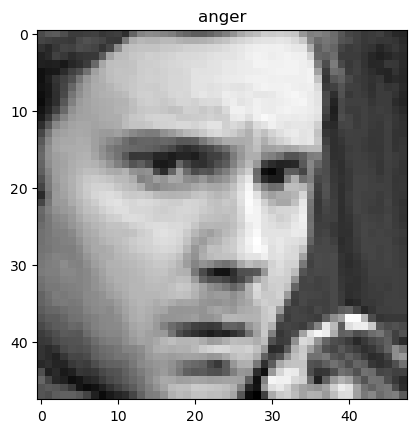

In [7]:
image=img_array[0]
print(image.squeeze().shape)
image=image.squeeze()
fig = plt.figure()
plt.imshow(image, cmap='gray')
plt.title(emotion_labels.get(df['emotion'].iloc[0]))
plt.show()


In [7]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

my_labels=df['emotion']
le = LabelEncoder()
labels = le.fit_transform(my_labels)
labels = np_utils.to_categorical(labels)
labels.shape

2023-11-22 20:44:03.273742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(35887, 7)

In [8]:
from sklearn.model_selection import train_test_split
X_train, remaining_data, y_train, remaining_labels = train_test_split(img_array, labels,
                                                    shuffle=True, stratify=labels,
                                                    test_size=0.2, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(remaining_data, remaining_labels,
                                                    shuffle=True, stratify=remaining_labels,
                                                    test_size=0.5, random_state=42)

    
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((28709, 48, 48, 1),
 (3589, 48, 48, 1),
 (3589, 48, 48, 1),
 (28709, 7),
 (3589, 7),
 (3589, 7))

In [9]:
X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import sparse_categorical_crossentropy

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(48, 48, 1), activation='elu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))          
model.add(BatchNormalization())
model.add(Dropout(0.5))
          

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))       
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=350, kernel_size=(3,3), activation='elu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))          
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))          
model.add(BatchNormalization())
model.add(Dropout(0.5))
          
model.add(Flatten())
          
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
          
model.add(Dense(7, activation='softmax'))
       
model.compile(optimizer='nadam',loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0

2023-11-22 20:44:13.243375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
897/897 [==============================] - 122s 135ms/step - loss: 1.8562 - accuracy: 0.3077 - val_loss: 1.5791 - val_accuracy: 0.3954
Epoch 2/200
897/897 [==============================] - 123s 137ms/step - loss: 1.4914 - accuracy: 0.4243 - val_loss: 1.4503 - val_accuracy: 0.4391
Epoch 3/200
897/897 [==============================] - 122s 136ms/step - loss: 1.3829 - accuracy: 0.4693 - val_loss: 1.2806 - val_accuracy: 0.5091
Epoch 4/200
897/897 [==============================] - 121s 135ms/step - loss: 1.3218 - accuracy: 0.4962 - val_loss: 1.2223 - val_accuracy: 0.5419
Epoch 5/200
897/897 [==============================] - 123s 137ms/step - loss: 1.2794 - accuracy: 0.5110 - val_loss: 1.1719 - val_accuracy: 0.5628
Epoch 6/200
897/897 [==============================] - 124s 138ms/step - loss: 1.2538 - accuracy: 0.5240 - val_loss: 1.2359 - val_accuracy: 0.5316
Epoch 7/200
897/897 [==============================] - 124s 138ms/step - loss: 1.2195 - accuracy: 0.5388 - val_loss: 1

897/897 [==============================] - 126s 141ms/step - loss: 0.6530 - accuracy: 0.7617 - val_loss: 1.0248 - val_accuracy: 0.6645
Epoch 112/200
897/897 [==============================] - 126s 140ms/step - loss: 0.6377 - accuracy: 0.7682 - val_loss: 1.0205 - val_accuracy: 0.6620
Epoch 113/200
897/897 [==============================] - 126s 140ms/step - loss: 0.6464 - accuracy: 0.7645 - val_loss: 1.0278 - val_accuracy: 0.6609
Epoch 114/200
897/897 [==============================] - 125s 140ms/step - loss: 0.6373 - accuracy: 0.7668 - val_loss: 1.0196 - val_accuracy: 0.6626
Epoch 115/200
897/897 [==============================] - 126s 140ms/step - loss: 0.6422 - accuracy: 0.7643 - val_loss: 1.0102 - val_accuracy: 0.6698
Epoch 116/200
897/897 [==============================] - 126s 140ms/step - loss: 0.6371 - accuracy: 0.7649 - val_loss: 1.0268 - val_accuracy: 0.6670
Epoch 117/200
897/897 [==============================] - 126s 140ms/step - loss: 0.6379 - accuracy: 0.7671 - val_loss: 1

897/897 [==============================] - 125s 140ms/step - loss: 0.5629 - accuracy: 0.7944 - val_loss: 1.0552 - val_accuracy: 0.6734
Epoch 167/200
897/897 [==============================] - 126s 140ms/step - loss: 0.5698 - accuracy: 0.7926 - val_loss: 1.0635 - val_accuracy: 0.6643
Epoch 168/200
897/897 [==============================] - 126s 140ms/step - loss: 0.5619 - accuracy: 0.7970 - val_loss: 1.0557 - val_accuracy: 0.6665
Epoch 169/200
897/897 [==============================] - 126s 140ms/step - loss: 0.5664 - accuracy: 0.7930 - val_loss: 1.0781 - val_accuracy: 0.6640
Epoch 170/200
897/897 [==============================] - 126s 140ms/step - loss: 0.5719 - accuracy: 0.7929 - val_loss: 1.0971 - val_accuracy: 0.6475
Epoch 171/200
897/897 [==============================] - 126s 140ms/step - loss: 0.5677 - accuracy: 0.7952 - val_loss: 1.0512 - val_accuracy: 0.6665
Epoch 172/200
897/897 [==============================] - 125s 140ms/step - loss: 0.5585 - accuracy: 0.7982 - val_loss: 1

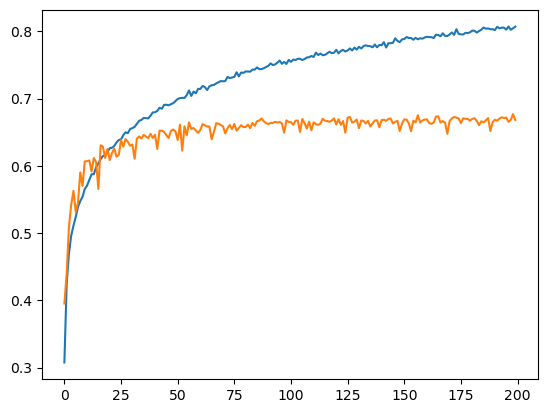

In [12]:
from matplotlib import pyplot
batch_size=32
steps_per_epoch=int(len(X_train) / batch_size)

history = model.fit(X_train, y_train, epochs=200, steps_per_epoch= steps_per_epoch, batch_size=batch_size, 
                    verbose=1,validation_data=(X_val, y_val))
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])

pyplot.show()

NameError: name 'history' is not defined

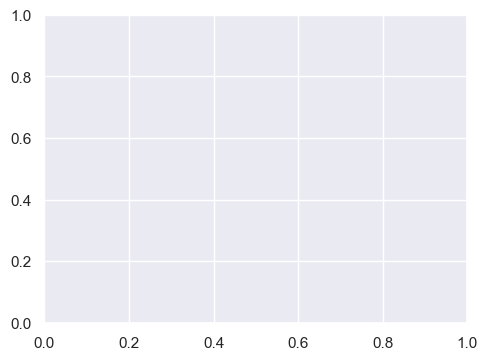

In [6]:
from matplotlib import pyplot
 
import seaborn as sns
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [2]:
y_pred=history.predict(X_test)

NameError: name 'history' is not defined

In [14]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.61      0.49      0.55       496
           1       0.78      0.54      0.64        54
           2       0.64      0.38      0.48       512
           3       0.81      0.84      0.83       899
           4       0.49      0.60      0.54       608
           5       0.80      0.78      0.79       400
           6       0.57      0.70      0.63       620

    accuracy                           0.65      3589
   macro avg       0.67      0.62      0.63      3589
weighted avg       0.66      0.65      0.65      3589



In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# precision = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# recall = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# f1_score = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 score:', f1_score)